In [8]:
import tqdm
import numpy as np
from matplotlib import pyplot as plt

import cv2 as cv

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

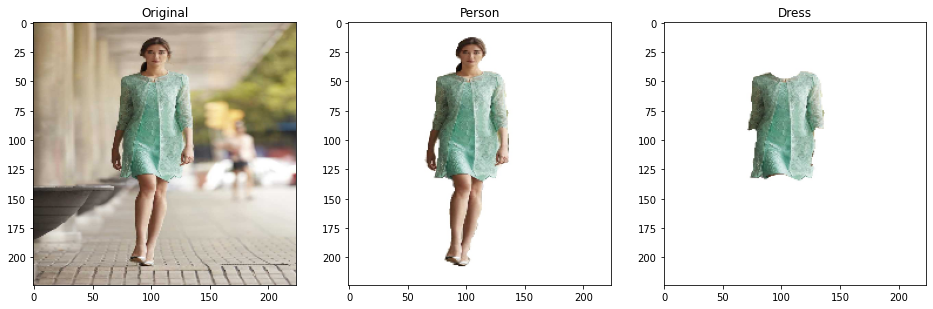

In [9]:
### PLOT ONE SAMPLE OF IMAGE IN THE DATA ###

original = cv.imread('original77.jpg')
original = cv.resize(original,(224,224))
dress = cv.imread('dress77.jpg')
dress = cv.resize(dress,(224,224))
body = cv.imread('body77.jpg')
body = cv.resize(body,(224,224))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Person')
plt.imshow(cv.cvtColor(body, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Dress')
plt.imshow(cv.cvtColor(dress, cv.COLOR_BGRA2RGB))

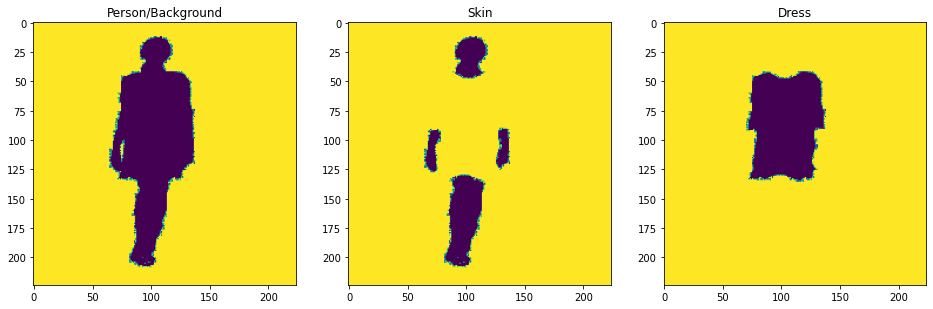

In [10]:
dress = cv.imread('dress77.jpg',0)
body = cv.imread('body77.jpg',0)

### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv.resize(dress,(224,224))

### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv.resize(body,(224,224))

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)

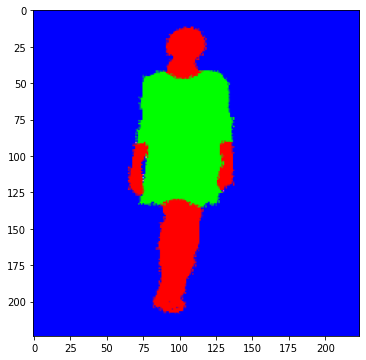

In [11]:
### COMBINE BACKGROUND, SKIN, DRESS ###

gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

In [12]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 77

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv.imread('./original77.jpg')
    original = cv.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    body = cv.imread('./body77.jpg',0)
    dress = cv.imread('./dress77.jpg',0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.reshape((-1,224,224,3))

images_original = np.asarray(images_original)
images_gt = np.asarray(images_gt)

100%|██████████| 77/77 [00:01<00:00, 57.46it/s]


In [13]:
def get_unet(mean_pixels, do_rate=0):
  
    inputs = Input((None, None, 3))
    preproc = Lambda(lambda x: (x - tf.constant(mean_pixels, dtype=tf.float32)))(inputs) 

    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(preproc))
    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(pool1))
    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(pool2))
    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(pool3))
    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv4))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(pool4))
    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(conv5))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(up6))
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv6))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(up7))
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv7))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(up8))
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv8))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(up9))
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv9))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
model = get_unet(mean)
model.fit(images_original, images_gt, epochs=120)

Epoch 1/120


ResourceExhaustedError:  OOM when allocating tensor with shape[32,224,224,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node model_1/conv2d_19/Relu
 (defined at c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\backend.py:4867)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5949]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/conv2d_19/Relu:
In[0] model_1/conv2d_19/BiasAdd (defined at c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\layers\convolutional.py:265)

Operation defined at: (most recent call last)
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 539, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\asyncio\base_events.py", line 1775, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\asyncio\events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\xus\AppData\Local\Temp\ipykernel_5804\3693565539.py", line 2, in <module>
>>>     model.fit(images_original, images_gt, epochs=120)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\layers\convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "c:\users\xus\appdata\local\programs\python\python37\lib\site-packages\keras\backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 

In [ ]:
### SAVE TRAINED MODEL ###

model.save('./fashion_unet.h5')